In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappop, heappush
import math

565 708
(407, 465) (199, 493)
[(407, 465), (375, 433), (375, 376), (342, 374), (330, 388), (302, 473), (285, 493), (199, 493)]


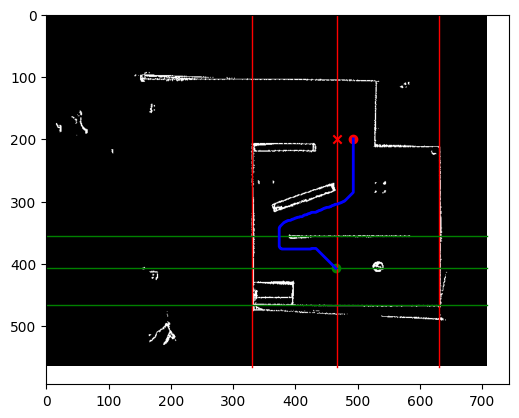

[(0.07692307692307693, -0.0), (1.3076923076923077, 1.2307692307692308), (3.5, 1.2307692307692308), (3.576923076923077, 2.5), (3.0384615384615383, 2.9615384615384617), (-0.23076923076923078, 4.038461538461538), (-1.0, 4.6923076923076925), (-1.0, 8.0)]


In [134]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappop, heappush
import math

def convert_coords(coords):
    # Coordinates of the origin of Map A and Map B
    origin_A = (407, 467)
    origin_B = (0, 0)

    # Scaling factor between the two grids
    scaling_factor = 26  # Assuming 20 units in Map A is equal to 1 unit in Map B

    # List of points on the path in Map A
    path_points_A = coords

    # Coordinate transformation
    path_points_B = [(-1 * ((x - origin_A[0]) / scaling_factor),
                    -1 * ((y - origin_A[1]) / scaling_factor))
                    for x, y in path_points_A]


    swapped_points = [(y, x) for x, y in path_points_B]
    # The path points are now transformed to Map B coordinates

    return swapped_points
def convert_coords_reverse(coords):
    # Coordinates of the origin of Map A and Map B
    origin_A = (400, 470)
    origin_B = (0, 0)

    # Scaling factor between the two grids
    scaling_factor = 1.0 / 10  # Assuming 20 units in Map A is equal to 1 unit in Map B

    # List of points on the path in Map B
    path_points_B = coords

    # Coordinate transformation
    path_points_A = [((x - origin_B[0]) / scaling_factor + origin_A[0],
                    (y - origin_B[1]) / scaling_factor + origin_A[1])
                    for x, y in path_points_B]

    swapped_points = [(y, x) for x, y in path_points_A]
    # The path points are now transformed to Map A coordinates

    return swapped_points


def astar_search(matrix, start, goal):
    rows, cols = matrix.shape
    
    # Define possible movements (up, down, left, right, diagonals)
    movements = [(0, -1), (0, 1), (-1, 0), (1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    
    # Create a priority queue (heap) to store nodes to be explored
    open_list = []
    
    # Initialize the start node with a priority of 0 (cost) and add it to the open list
    start_node = (0, start, None)
    heappush(open_list, start_node)
    
    # Create a dictionary to store the cost of reaching each node from the start node
    g_costs = {start: 0}
    
    # Create a dictionary to store the parent node of each explored node
    parents = {}
    
    while open_list:
        # Get the node with the lowest cost (priority) from the open list
        current_cost, current_node, parent_node = heappop(open_list)
        
        # Check if the current node is the goal node
        if current_node == goal:
            # Build the path from the goal node to the start node
            path = []
            while current_node is not None:
                path.append(current_node)
                current_node = parents.get(current_node)  # Use get() to handle missing keys
            return path[::-1]
        
        # Explore the neighboring nodes
        for movement in movements:
            dx, dy = movement
            neighbor = (current_node[0] + dx, current_node[1] + dy)
            
            # Check if the neighbor is within the matrix boundaries
            if neighbor[0] < 0 or neighbor[0] >= rows or neighbor[1] < 0 or neighbor[1] >= cols:
                continue
            
            # Check if the neighbor is an obstacle (white pixel)
            if matrix[neighbor] == 0:
                continue
            
            # Calculate the cost to reach the neighbor from the start node
            neighbor_cost = g_costs[current_node] + 1
            
            # Check if the neighbor has not been visited or the new cost is lower than the previous cost
            if neighbor not in g_costs or neighbor_cost < g_costs[neighbor]:
                # Update the cost to reach the neighbor
                g_costs[neighbor] = neighbor_cost
                
                # Calculate the heuristic (Euclidean distance) from the neighbor to the goal node
                heuristic = np.linalg.norm(np.array(neighbor) - np.array(goal))
                
                # Calculate the priority (cost + heuristic) of the neighbor node
                priority = neighbor_cost + heuristic
                
                # Add the neighbor node to the open list with its priority
                heappush(open_list, (priority, neighbor, current_node))
                
                # Set the parent of the neighbor node
                parents[neighbor] = current_node
    
    # No path found
    print("no path found")
    return None

def point_line_distance(point, start, end):
    # Calculate the distance between point and the line defined by start and end
    x, y = point
    x1, y1 = start
    x2, y2 = end
    numerator = abs((y2 - y1) * x - (x2 - x1) * y + x2 * y1 - y2 * x1)
    denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    return numerator / denominator

def simplify_path(points, epsilon):
    if len(points) < 3:
        return points

    start_point = points[0]
    end_point = points[-1]

    # Find the point with the maximum distance
    max_distance = 0
    max_index = 0
    for i in range(1, len(points) - 1):
        distance = point_line_distance(points[i], start_point, end_point)
        if distance > max_distance:
            max_distance = distance
            max_index = i

    simplified_path = []

    # If the maximum distance is greater than epsilon, recursively simplify the two subpaths
    if max_distance > epsilon:
        left_subpath = simplify_path(points[:max_index + 1], epsilon)
        right_subpath = simplify_path(points[max_index:], epsilon)
        simplified_path = left_subpath[:-1] + right_subpath
    else:
        simplified_path = [start_point, end_point]

    return simplified_path


# Read the image and convert it to a matrix
image = cv2.imread('base.png')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, threshold_image = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY)
binary_image = cv2.bitwise_not(threshold_image)
original_matrix = np.array(binary_image)
dil = cv2.morphologyEx(binary_image,cv2.MORPH_DILATE,np.ones((30,30)))
binary_image = cv2.bitwise_not(dil)
matrix = np.array(binary_image)

print(len(matrix),len(matrix[0]))


# Define the start and goal positions
start = tuple(map(int,(407, 465)))
goal = tuple(map(int,(199,493)))

print(start,goal)

# Perform A* search
path = astar_search(matrix, start, goal)


# Display the matrix with grid lines
plt.imshow(original_matrix, cmap='gray')

# Add grid lines
grid_size = 30  # Number of pixels between each grid line
rows, cols = original_matrix.shape

if path is not None:

    epsilon = 2.0 
    simplified_path = simplify_path(path, epsilon)
    print(simplified_path)

    plt.plot((331,331), (565,0), color='red', linewidth=1)
    plt.plot((630,630), (565,0), color='red', linewidth=1)
    plt.plot((480-13,480-13), (565,0), color='red', linewidth=1)

    plt.plot((0,708), (355,355), color='green', linewidth=1)
    plt.plot((0,708), (355+104+7,355+104+7), color='green', linewidth=1)
    plt.plot((0.5,708), (355+52,355+52), color='green', linewidth=1)


    # Plot the path
    if simplified_path is not None:
        path_x = [pos[1] for pos in path]
        path_y = [pos[0] for pos in path]
        plt.plot(path_x, path_y, color='blue', linewidth=2)

# Mark the start and goal positions
plt.scatter(start[1], start[0], c='green', marker='o')
plt.scatter(goal[1], goal[0], c='red', marker='o')

plt.scatter(467,199,c ='red',marker='x' ) # (0,8)

plt.show()

actual_path = convert_coords(simplified_path)

print(actual_path)


In [132]:
import numpy as np

def convert_coords(coords):
    # Coordinates of the origin of Map A and Map B
    origin_A = (407, 467)
    origin_B = (0, 0)

    # Scaling factor between the two grids
    scaling_factor = 26  # Assuming 20 units in Map A is equal to 1 unit in Map B

    # List of points on the path in Map A
    path_points_A = coords

    # Coordinate transformation
    path_points_B = [(-1 * ((x - origin_A[0]) / scaling_factor),
                    -1 * ((y - origin_A[1]) / scaling_factor))
                    for x, y in path_points_A]


    swapped_points = [(y, x) for x, y in path_points_B]
    # The path points are now transformed to Map B coordinates

    return swapped_points

def convert_coords_reverse(coords):
    origin_A = (467, 407)
    origin_B = (0, 0)

    scaling_factor = 26  # Assuming 20 units in Map A is equal to 1 unit in Map B

    # List of points on the path in Map B
    path_points_B = coords

    # Coordinate transformation
    path_points_A = [((x * scaling_factor) + origin_A[0],
                    (y * scaling_factor ) - origin_A[1])
                    for x, y in path_points_B]

    swapped_points = np.abs([(y, x) for x, y in path_points_A])

    return swapped_points

start = (-0.012329010794117424, 0.05528094926244336)
goal =  (1,8)

s = convert_coords_reverse([start,goal])
system_converted_coords = np.around(s,0)



s = convert_coords(system_converted_coords)
origional = np.around(s,0)

print(system_converted_coords)
print(origional)

[[406. 467.]
 [199. 493.]]
[[-0.  0.]
 [-1.  8.]]


In [123]:
start = tuple(map(int,system_converted_coords[0]))
goal = tuple(map(int,system_converted_coords[1]))

print(start,goal)

(406, 467) (199, 441)
